In [ ]:
!pip install -q torchsummary

from google.colab import files
import os

print("Upload your kaggle.json file containing your API keys")
if not os.path.exists(r"/content/fer2018.zip"):
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d ashishpatel26/fer2018
!unzip -qq  fer2018.zip -d datasets/

Upload your kaggle.json file containing your API keys


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes
 80% 77.0M/96.6M [00:00<00:00, 185MB/s]
100% 96.6M/96.6M [00:00<00:00, 197MB/s]


In [ ]:
import warnings
warnings.filterwarnings("ignore")


import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from torchsummary import summary

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid
import math

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', 20)


%matplotlib inline  

In [ ]:
dataset = pd.read_csv('datasets/fer20131.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
# extracting pixel data from pixel column
# convert it to integer
# drop original pixel column
# add all pixels as individual column

pixels = []

for pix in dataset.pixels:
    values = [int(i) for i in pix.split()]
    pixels.append(values)

pixels = np.array(pixels)

# rescaling pixel values
pixels = pixels/255.0


dataset.drop(columns=['pixels'], axis=1, inplace=True)

pix_cols = [] # for keeping track of column names

# add each pixel value as a column
for i in range(pixels.shape[1]):
    name = f'pixel_{i}'
    pix_cols.append(name)
    dataset[name] = pixels[:, i]

In [ ]:
emotions = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

In [ ]:
class FERDataset(Dataset):
    '''
        Parse raw data to form a Dataset of (X, y).
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.tensor_transform = T.ToTensor()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = int(row['emotion'])
        img = np.copy(row[pix_cols].values.reshape(48, 48))
        img.setflags(write=True)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        else:
            img = self.tensor_transform(img)

        return img, img_id

In [ ]:
def image_transformations() -> (object, object):
    '''
        Return transformations to be applied.
        Input:
            None
        Output:
            train_tfms: transformations to be applied on the training set
            valid_tfms: transformations to be applied on the validation or test set
    '''

    train_trans = [      
        T.RandomCrop(48, padding=4, padding_mode='reflect'),     
        T.RandomRotation(15),
        T.RandomAffine(
            degrees=0,
            translate=(0.01, 0.12),
            shear=(0.01, 0.03),
        ),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
    ]

    val_trans = [
        T.ToTensor(), 
    ]

    train_transformations = T.Compose(train_trans)
    valid_tfms = T.Compose(val_trans)

    return train_transformations, valid_tfms

In [ ]:
def get_train_dataset(dataframe: object, transformation: bool=True) -> (object, object):
    '''
        Returns an object on FERDataset class
        Input:
            dataframe: object -> DataFrame object containing the whole data
            transformation: bool [optional] ->  Apply transformations
    '''

    # extracts rows specific to Training, PublicTest
    dataframe = dataframe.loc[dataframe.Usage.isin(['Training', 'PublicTest'])]
    # drop Usage column as it's no longer needed    
    dataframe = dataframe.drop('Usage', axis=1)

    # split dataset into training and validation set
    np.random.seed(42)  
    msk = np.random.rand(len(dataframe)) < 0.8

    train_df = dataframe[msk].reset_index()
    val_df = dataframe[~msk].reset_index()

    # get transformations
    if transformation:
        train_tfms, valid_tfms = image_transformations()
    else:
        train_tfms, valid_tfms = None, None

    # fetch dataset
    train_ds = FERDataset(dataframe, transform=train_tfms)
    val_ds = FERDataset(dataframe, transform=valid_tfms)
    return train_ds, val_ds

In [ ]:
def get_train_dataloader(dataframe: object, transformation=True, batch_size: int=64) -> (object, object):
    '''
        Returns train and test dataloaders.
        Input:
            dataframe: dataset DataFrame object
            batch_size: [optional] int
        Output:
            train_dl: train dataloader object
            valid_dl: validation dataloader object
    '''
    # fetech train and validation dataset
    train_ds, valid_ds = get_train_dataset(dataframe, transformation=transformation)
    
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                     num_workers=3, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)
    
    return train_dl, valid_dl

def get_test_dataloader(dataframe: object, batch_size: int=128) -> object:
    '''
        Returns test set dataloaders.
        Input:
            dataframe: dataset DataFrame object
            batch_size: [optional] int
        Output:
            test_dl: test dataloader object
    '''
    # extracts rows specific to PrivateTest
    test_df = dataframe.loc[dataset.Usage.isin(['PrivateTest'])]

    # drop Usage column as it's no longer needed
    test_df = test_df.drop('Usage', axis=1)

    # get transformations same as validation set
    _, valid_tfms = image_transformations()
    
    test_dataset = FERDataset(test_df, transform=valid_tfms)
    test_dl = DataLoader(test_dataset, batch_size, num_workers=3 , pin_memory=True)

    # move loader to GPU (class defined ahead)
    test_dl = DeviceDataLoader(test_dl, device)
    return test_dl

In [ ]:
train_dl_un, _ = get_train_dataloader(dataset, transformation=False)
train_dl, _ = get_train_dataloader(dataset)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Can be used for any Image Classification task

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {'loss': loss, 'acc': acc.detach()}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def get_metrics_epoch_end(self, outputs, validation=True):
        if validation:
            loss_ = 'val_loss'
            acc_ = 'val_acc'
        else:
            loss_ = 'loss'
            acc_ = 'acc'

        batch_losses = [x[f'{loss_}'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x[f'{acc_}'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {f'{loss_}': epoch_loss.detach().item(), f'{acc_}': epoch_acc.detach().item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        print(f"Epoch: {epoch+1}/{num_epochs} -> lr: {result['lrs'][-1]:.5f} loss: {result['loss']:.4f}, acc: {result['acc']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}\n")

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [ ]:
# code based on example https://www.kaggle.com/veb101/facial-expression-recognition-using-pytorch
def conv_block(in_channels, out_channels, pool=False):
    layers = [
              nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)
    ]

    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2))
    
    return nn.Sequential(*layers)

In [ ]:
# updated channels for the use case
# added and additional layer in classifier

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 16, pool=False) # 16 x 48 x 48
        self.conv2 = conv_block(16, 32, pool=True) # 32 x 24 x 24
        self.res1 = nn.Sequential( #  32 x 24 x 24
            conv_block(32, 32, pool=False), 
            conv_block(32, 32, pool=False)
        )

        self.conv3 = conv_block(32, 64, pool=True) # 64 x 12 x 12
        self.conv4 = conv_block(64, 128, pool=True) # 128 x 6 x 6

        self.res2 = nn.Sequential( # 128 x 6 x 6
             conv_block(128, 128), 
             conv_block(128, 128)
        )
        
        self.classifier = nn.Sequential(
            nn.MaxPool2d(kernel_size=2), # 128 x 3 x 3
            nn.Flatten(), 
            nn.Linear(128*3*3, 512), #4608 ---> 3000
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256), #512 ---> 256
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 108), #256 ---> 108
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(108, 32), #108 ---> 132
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 7)
        )
        self.network = nn.Sequential(
            self.conv1,
            self.conv2,
            self.res1,
            self.conv3,
            self.conv4,
            self.res2,
            self.classifier,
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out       

    def __repr__(self):
        return f"{self.network}"
    
    def __str__(self):
        summary(self.network, (1, 48, 48)) 

In [ ]:
@torch.no_grad()
def evaluate(model: object, val_loader: object) -> dict:
    '''
        Evaluate model on the validation set
        Input:
            model: training model object
            val_loder: validation data loader object
        Output:
            validation metrics
    '''

    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.get_metrics_epoch_end(outputs=outputs, validation=True)


def get_lr(optimizer: object) -> float:
    ''' Returns current learning rate'''

    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_model(model_name: str,
              model: object, 
              epochs: int, 
              max_lr: float, 
              train_loader: object, 
              val_loader: object,
              weight_decay: float=0, 
              grad_clip: float=None, 
              opt_func: object=torch.optim.SGD):
    '''
        This function is responsible for training our model.
        We use a One Cycle learning rate policy to update our learning rate 
        with each epoch.
        The best model is saved during each epoch.
        Input:
            model_name: str 
            model: object
            epochs: int -> Max epochs
            max_lr: float -> Maximum allowed learning rate during learning
            train_loader: training set data loader
            val_loader: validation set data loader
            weight_decay: float -> value to decrease weights during training of each batch
            grad_clip: float -> maximum allowed gradient value
            opt_func: optimzer object
        Output:
            history: list of metrics
    '''

    torch.cuda.empty_cache()
    BEST_VAL_SCORE = 0.0 # for keeping track of best model score
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=max_lr,
                                                    epochs=epochs, 
                                                    steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        train_history = []
        lrs = []

        # Training Phase 
        model.train()
        for batch in tqdm(train_loader, ascii=True, desc=f'Epoch: {epoch+1}/{epochs}'):
            info = model.training_step(batch)
            loss = info['loss']
            # contains batch loss and acc for training phase
            train_history.append(info)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            scheduler.step()


        train_result = model.get_metrics_epoch_end(train_history, validation=False)
        val_result = evaluate(model, val_loader)
        result = {**train_result, **val_result}
        result['lrs'] = lrs
        model.epoch_end(epoch, result, epochs)

        # Save the best model
        if result['val_acc'] > BEST_VAL_SCORE:
            BEST_VAL_SCORE = result['val_acc']
            save_name = f"{model_name}_epoch-{epoch+1}_score-{round(result['val_acc'], 4)}.pth"
            !rm -f '{model_name}'_*
            torch.save(model.state_dict(), save_name)

        history.append(result)
    return history

In [ ]:
# functions to fetch test dataset and generate submission file for best model

def load_best(model_name: str) -> object:
    '''Returns the best model'''

    # get model defintion
    best_model = models[model_name]

    # load trained weights
    path = r"./"
    file_path = ''
    
    for i in os.listdir(path):
        if os.path.isfile(os.path.join(path,i)) and i.startswith(f'{model_name}'):
            file_path = os.path.join(path, i)
            
    print(f"Loaded model: {file_path[2:]} weights.")
    best_model.load_state_dict(torch.load(file_path))

    # move model to gpu
    best_model = to_device(best_model, device)
    return best_model   


@torch.no_grad()
def generate_prediction(model_name: str) -> None:
    '''Generate prediction on the test set'''

    # load test dataset
    test_dl = get_test_dataloader(dataset)
    
    # load model
    model = load_best(model_name)

    # clear cuda cache
    torch.cuda.empty_cache()

    # generate prediction using the validation step method defined in Base class
    with torch.no_grad():
        model.eval()
        outputs = [model.validation_step(batch) for batch in test_dl]
        metrics = model.get_metrics_epoch_end(outputs=outputs, validation=True)

    print(f"Test Scores:\n Loss: {round(metrics['val_loss'], 3)}, Accuracy: {round(metrics['val_acc'], 3)}")

In [ ]:
def end_to_end(model_name: str, parameters: dict=None) -> dict:
    '''
        A simple function end-to-end training and testing on the selected model.
        Inputs:
            model_name: str -> chosen model name
            parameters: dict -> dictionary of hyperparameters for the model
        Outputs:
            history: dict -> dictionary containing model metrics(loss, score, lr)

    '''
    torch.cuda.empty_cache()

    # hyperparameters
    BATCH_SIZE = 512 # batch_sizes[model_name]
    epochs = parameters["epochs"]
    max_lr = parameters["max_lr"]
    weight_decay = parameters["weight_decay"]
    grad_clip = parameters["grad_clip"]
    opt_func = parameters["opt_func"]

    # get transformed dataset
    train_dl, valid_dl = get_train_dataloader(dataset, batch_size=BATCH_SIZE)
    # move dataset to use GPU
    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)

    # get model
    model = models[model_name]

    # move model to GPU
    model = to_device(model, device)
    
    # train model
    history = fit_model(
                model_name,
                model, 
                epochs, 
                max_lr, 
                train_dl, 
                valid_dl,
                weight_decay, 
                grad_clip, 
                opt_func
            )

    # cleaning
    torch.cuda.empty_cache()

    # generate predictions
    print("Genearating predictions on the Test set")
    generate_prediction(model_name)
    return history

In [ ]:
# plotting metrics

def plot_accuracies(history):
    train_acc = [r['acc'] for r in history]
    val_acc = [r['val_acc'] for r in history]
    plt.plot(train_acc, '-kx', label="train_acc")
    plt.plot(val_acc, '-rx', label="val_acc")
    plt.legend()
    _ = plt.xticks(ticks=range(len(train_acc)), 
                   labels=[str(i) for i in range(1, len(train_acc)+1)])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. epochs')

def plot_losses(history):
    train_losses = [r['loss'] for r in history]
    val_losses = [r['val_loss'] for r in history]
    plt.plot(train_losses, '-kx', label="train_loss")
    plt.plot(val_losses, '-rx', label="val_loss")
    plt.legend()
    _ = plt.xticks(ticks=range(len(train_losses)), 
                   labels=[str(i) for i in range(1, len(train_losses)+1)])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. epochs')

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
models = {
    'ResNet': ResNet9(in_channels=1, num_classes=7),
}

In [ ]:
# TRAINING CONSTANTS

training_parameters = {
    "epochs": 100,
    "max_lr": 0.01,
    "weight_decay": 0.1,
    "grad_clip": 1e-4,
    "opt_func": torch.optim.Adam,
}

In [ ]:
model_name = "ResNet"

history = end_to_end(model_name, training_parameters)

Epoch: 1/100: 100%|##########| 64/64 [01:27<00:00,  1.36s/it]


Epoch: 1/100 -> lr: 0.00043 loss: 1.9312, acc: 0.1869, val_loss: 1.9346, val_acc: 0.1421



Epoch: 3/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 2/100 -> lr: 0.00050 loss: 1.9361, acc: 0.1554, val_loss: 1.9404, val_acc: 0.1421



Epoch: 4/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 3/100 -> lr: 0.00063 loss: 1.9418, acc: 0.1429, val_loss: 1.9432, val_acc: 0.1421



Epoch: 5/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 4/100 -> lr: 0.00081 loss: 1.9439, acc: 0.1432, val_loss: 1.9447, val_acc: 0.1421



Epoch: 6/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 5/100 -> lr: 0.00104 loss: 1.9451, acc: 0.1412, val_loss: 1.9453, val_acc: 0.1421



Epoch: 7/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 6/100 -> lr: 0.00131 loss: 1.9455, acc: 0.1422, val_loss: 1.9456, val_acc: 0.1421



Epoch: 8/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 7/100 -> lr: 0.00163 loss: 1.9456, acc: 0.1422, val_loss: 1.9456, val_acc: 0.1421



Epoch: 8/100: 100%|##########| 64/64 [01:27<00:00,  1.37s/it]


Epoch: 8/100 -> lr: 0.00198 loss: 1.9456, acc: 0.1716, val_loss: 1.9456, val_acc: 0.2509



Epoch: 10/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 9/100 -> lr: 0.00237 loss: 1.9456, acc: 0.2513, val_loss: 1.9456, val_acc: 0.2509



Epoch: 11/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 10/100 -> lr: 0.00280 loss: 1.9456, acc: 0.2463, val_loss: 1.9456, val_acc: 0.1703



Epoch: 12/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 11/100 -> lr: 0.00324 loss: 1.9456, acc: 0.2446, val_loss: 1.9456, val_acc: 0.2509



Epoch: 13/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 12/100 -> lr: 0.00371 loss: 1.9456, acc: 0.2516, val_loss: 1.9456, val_acc: 0.2509



Epoch: 14/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 13/100 -> lr: 0.00420 loss: 1.9456, acc: 0.2447, val_loss: 1.9456, val_acc: 0.2509



Epoch: 15/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 14/100 -> lr: 0.00469 loss: 1.9456, acc: 0.2323, val_loss: 1.9456, val_acc: 0.1703



Epoch: 16/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 15/100 -> lr: 0.00520 loss: 1.9456, acc: 0.2166, val_loss: 1.9456, val_acc: 0.2509



Epoch: 17/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 16/100 -> lr: 0.00570 loss: 1.9456, acc: 0.2201, val_loss: 1.9456, val_acc: 0.2509



Epoch: 18/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 17/100 -> lr: 0.00619 loss: 1.9456, acc: 0.2154, val_loss: 1.9456, val_acc: 0.2509



Epoch: 19/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 18/100 -> lr: 0.00668 loss: 1.9456, acc: 0.2163, val_loss: 1.9456, val_acc: 0.1703



Epoch: 20/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 19/100 -> lr: 0.00715 loss: 1.9456, acc: 0.2157, val_loss: 1.9456, val_acc: 0.2509



Epoch: 21/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 20/100 -> lr: 0.00760 loss: 1.9456, acc: 0.2044, val_loss: 1.9456, val_acc: 0.1726



Epoch: 22/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 21/100 -> lr: 0.00802 loss: 1.9456, acc: 0.2029, val_loss: 1.9456, val_acc: 0.1703



Epoch: 23/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 22/100 -> lr: 0.00841 loss: 1.9456, acc: 0.2109, val_loss: 1.9456, val_acc: 0.1377



Epoch: 24/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 23/100 -> lr: 0.00877 loss: 1.9456, acc: 0.2077, val_loss: 1.9456, val_acc: 0.2509



Epoch: 25/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 24/100 -> lr: 0.00908 loss: 1.9456, acc: 0.1975, val_loss: 1.9456, val_acc: 0.2509



Epoch: 26/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 25/100 -> lr: 0.00936 loss: 1.9456, acc: 0.1784, val_loss: 1.9456, val_acc: 0.2509



Epoch: 27/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 26/100 -> lr: 0.00958 loss: 1.9456, acc: 0.1992, val_loss: 1.9456, val_acc: 0.2509



Epoch: 28/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 27/100 -> lr: 0.00976 loss: 1.9456, acc: 0.1990, val_loss: 1.9456, val_acc: 0.1726



Epoch: 29/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 28/100 -> lr: 0.00989 loss: 1.9456, acc: 0.1941, val_loss: 1.9456, val_acc: 0.2509



Epoch: 30/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 29/100 -> lr: 0.00997 loss: 1.9456, acc: 0.1977, val_loss: 1.9456, val_acc: 0.1703



Epoch: 31/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 30/100 -> lr: 0.01000 loss: 1.9456, acc: 0.1790, val_loss: 1.9456, val_acc: 0.1377



Epoch: 32/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 31/100 -> lr: 0.00999 loss: 1.9456, acc: 0.1925, val_loss: 1.9456, val_acc: 0.2509



Epoch: 33/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 32/100 -> lr: 0.00998 loss: 1.9456, acc: 0.1991, val_loss: 1.9456, val_acc: 0.1377



Epoch: 34/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 33/100 -> lr: 0.00995 loss: 1.9456, acc: 0.1912, val_loss: 1.9456, val_acc: 0.2509



Epoch: 35/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 34/100 -> lr: 0.00992 loss: 1.9456, acc: 0.1915, val_loss: 1.9456, val_acc: 0.1703



Epoch: 36/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 35/100 -> lr: 0.00987 loss: 1.9456, acc: 0.2005, val_loss: 1.9456, val_acc: 0.2509



Epoch: 37/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 36/100 -> lr: 0.00982 loss: 1.9456, acc: 0.2063, val_loss: 1.9456, val_acc: 0.2509



Epoch: 38/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 37/100 -> lr: 0.00976 loss: 1.9456, acc: 0.1963, val_loss: 1.9456, val_acc: 0.1703



Epoch: 39/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 38/100 -> lr: 0.00968 loss: 1.9456, acc: 0.1853, val_loss: 1.9456, val_acc: 0.2509



Epoch: 40/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 39/100 -> lr: 0.00960 loss: 1.9456, acc: 0.1951, val_loss: 1.9456, val_acc: 0.1703



Epoch: 41/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 40/100 -> lr: 0.00950 loss: 1.9456, acc: 0.2002, val_loss: 1.9456, val_acc: 0.2509



Epoch: 42/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 41/100 -> lr: 0.00940 loss: 1.9456, acc: 0.1885, val_loss: 1.9456, val_acc: 0.2509



Epoch: 43/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 42/100 -> lr: 0.00929 loss: 1.9456, acc: 0.1851, val_loss: 1.9456, val_acc: 0.2509



Epoch: 44/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 43/100 -> lr: 0.00917 loss: 1.9456, acc: 0.1974, val_loss: 1.9456, val_acc: 0.1726



Epoch: 45/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 44/100 -> lr: 0.00905 loss: 1.9456, acc: 0.1891, val_loss: 1.9456, val_acc: 0.1726



Epoch: 46/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 45/100 -> lr: 0.00891 loss: 1.9456, acc: 0.1851, val_loss: 1.9456, val_acc: 0.1703



Epoch: 47/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 46/100 -> lr: 0.00877 loss: 1.9456, acc: 0.1898, val_loss: 1.9456, val_acc: 0.2509



Epoch: 48/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 47/100 -> lr: 0.00861 loss: 1.9456, acc: 0.1934, val_loss: 1.9456, val_acc: 0.2509



Epoch: 49/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 48/100 -> lr: 0.00846 loss: 1.9456, acc: 0.2040, val_loss: 1.9457, val_acc: 0.1377



Epoch: 50/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 49/100 -> lr: 0.00829 loss: 1.9456, acc: 0.1848, val_loss: 1.9456, val_acc: 0.1703



Epoch: 51/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 50/100 -> lr: 0.00812 loss: 1.9456, acc: 0.1964, val_loss: 1.9456, val_acc: 0.1421



Epoch: 52/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 51/100 -> lr: 0.00794 loss: 1.9456, acc: 0.1861, val_loss: 1.9456, val_acc: 0.1726



Epoch: 53/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 52/100 -> lr: 0.00775 loss: 1.9456, acc: 0.1948, val_loss: 1.9456, val_acc: 0.1377



Epoch: 54/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 53/100 -> lr: 0.00756 loss: 1.9456, acc: 0.1783, val_loss: 1.9456, val_acc: 0.2509



Epoch: 55/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 54/100 -> lr: 0.00737 loss: 1.9456, acc: 0.1793, val_loss: 1.9456, val_acc: 0.2509



Epoch: 56/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 55/100 -> lr: 0.00717 loss: 1.9456, acc: 0.2002, val_loss: 1.9456, val_acc: 0.2509



Epoch: 57/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 56/100 -> lr: 0.00697 loss: 1.9456, acc: 0.1930, val_loss: 1.9456, val_acc: 0.2509



Epoch: 58/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 57/100 -> lr: 0.00676 loss: 1.9456, acc: 0.2050, val_loss: 1.9456, val_acc: 0.1377



Epoch: 59/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 58/100 -> lr: 0.00655 loss: 1.9456, acc: 0.1932, val_loss: 1.9456, val_acc: 0.1377



Epoch: 60/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 59/100 -> lr: 0.00633 loss: 1.9456, acc: 0.1857, val_loss: 1.9456, val_acc: 0.1377



Epoch: 61/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 60/100 -> lr: 0.00611 loss: 1.9456, acc: 0.1815, val_loss: 1.9456, val_acc: 0.2509



Epoch: 62/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 61/100 -> lr: 0.00589 loss: 1.9456, acc: 0.2078, val_loss: 1.9456, val_acc: 0.2509



Epoch: 63/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 62/100 -> lr: 0.00567 loss: 1.9456, acc: 0.1919, val_loss: 1.9456, val_acc: 0.1703



Epoch: 64/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 63/100 -> lr: 0.00545 loss: 1.9456, acc: 0.1972, val_loss: 1.9456, val_acc: 0.1726



Epoch: 65/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 64/100 -> lr: 0.00522 loss: 1.9456, acc: 0.1785, val_loss: 1.9456, val_acc: 0.1703



Epoch: 66/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 65/100 -> lr: 0.00500 loss: 1.9456, acc: 0.1997, val_loss: 1.9456, val_acc: 0.1726



Epoch: 67/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 66/100 -> lr: 0.00478 loss: 1.9456, acc: 0.1840, val_loss: 1.9456, val_acc: 0.2509



Epoch: 68/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 67/100 -> lr: 0.00455 loss: 1.9456, acc: 0.1880, val_loss: 1.9456, val_acc: 0.2509



Epoch: 69/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 68/100 -> lr: 0.00433 loss: 1.9456, acc: 0.2077, val_loss: 1.9456, val_acc: 0.1726



Epoch: 70/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 69/100 -> lr: 0.00411 loss: 1.9456, acc: 0.1792, val_loss: 1.9456, val_acc: 0.2509



Epoch: 71/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 70/100 -> lr: 0.00389 loss: 1.9456, acc: 0.1871, val_loss: 1.9456, val_acc: 0.1377



Epoch: 72/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 71/100 -> lr: 0.00367 loss: 1.9456, acc: 0.1717, val_loss: 1.9456, val_acc: 0.2509



Epoch: 73/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 72/100 -> lr: 0.00345 loss: 1.9456, acc: 0.2008, val_loss: 1.9456, val_acc: 0.1726



Epoch: 74/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 73/100 -> lr: 0.00324 loss: 1.9456, acc: 0.1985, val_loss: 1.9456, val_acc: 0.1377



Epoch: 75/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 74/100 -> lr: 0.00303 loss: 1.9456, acc: 0.2003, val_loss: 1.9456, val_acc: 0.1377



Epoch: 76/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 75/100 -> lr: 0.00283 loss: 1.9456, acc: 0.1852, val_loss: 1.9456, val_acc: 0.1703



Epoch: 77/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 76/100 -> lr: 0.00263 loss: 1.9456, acc: 0.1854, val_loss: 1.9456, val_acc: 0.1703



Epoch: 78/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 77/100 -> lr: 0.00244 loss: 1.9456, acc: 0.1902, val_loss: 1.9456, val_acc: 0.1377



Epoch: 79/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 78/100 -> lr: 0.00225 loss: 1.9456, acc: 0.2079, val_loss: 1.9456, val_acc: 0.2509



Epoch: 80/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 79/100 -> lr: 0.00206 loss: 1.9456, acc: 0.1959, val_loss: 1.9456, val_acc: 0.2509



Epoch: 81/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 80/100 -> lr: 0.00188 loss: 1.9456, acc: 0.2085, val_loss: 1.9456, val_acc: 0.1726



Epoch: 82/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 81/100 -> lr: 0.00171 loss: 1.9456, acc: 0.2068, val_loss: 1.9456, val_acc: 0.2509



Epoch: 83/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 82/100 -> lr: 0.00154 loss: 1.9456, acc: 0.2079, val_loss: 1.9456, val_acc: 0.2509



Epoch: 84/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 83/100 -> lr: 0.00139 loss: 1.9456, acc: 0.2160, val_loss: 1.9456, val_acc: 0.1726



Epoch: 85/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 84/100 -> lr: 0.00123 loss: 1.9456, acc: 0.1949, val_loss: 1.9456, val_acc: 0.2509



Epoch: 86/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 85/100 -> lr: 0.00109 loss: 1.9456, acc: 0.2002, val_loss: 1.9456, val_acc: 0.1726



Epoch: 87/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 86/100 -> lr: 0.00095 loss: 1.9456, acc: 0.1944, val_loss: 1.9456, val_acc: 0.1703



Epoch: 88/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 87/100 -> lr: 0.00083 loss: 1.9456, acc: 0.2051, val_loss: 1.9456, val_acc: 0.2509



Epoch: 89/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 88/100 -> lr: 0.00071 loss: 1.9456, acc: 0.2319, val_loss: 1.9456, val_acc: 0.1703



Epoch: 90/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 89/100 -> lr: 0.00060 loss: 1.9456, acc: 0.2165, val_loss: 1.9456, val_acc: 0.1726



Epoch: 91/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 90/100 -> lr: 0.00050 loss: 1.9456, acc: 0.2181, val_loss: 1.9456, val_acc: 0.2509



Epoch: 92/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 91/100 -> lr: 0.00040 loss: 1.9456, acc: 0.2236, val_loss: 1.9456, val_acc: 0.2509



Epoch: 93/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 92/100 -> lr: 0.00032 loss: 1.9456, acc: 0.2105, val_loss: 1.9456, val_acc: 0.2509



Epoch: 94/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 93/100 -> lr: 0.00024 loss: 1.9456, acc: 0.2509, val_loss: 1.9456, val_acc: 0.2509



Epoch: 95/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 94/100 -> lr: 0.00018 loss: 1.9456, acc: 0.2492, val_loss: 1.9456, val_acc: 0.2509



Epoch: 96/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 95/100 -> lr: 0.00013 loss: 1.9456, acc: 0.2010, val_loss: 1.9456, val_acc: 0.2509



Epoch: 97/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 96/100 -> lr: 0.00008 loss: 1.9456, acc: 0.2296, val_loss: 1.9456, val_acc: 0.2509



Epoch: 98/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 97/100 -> lr: 0.00005 loss: 1.9456, acc: 0.2502, val_loss: 1.9456, val_acc: 0.2509



Epoch: 99/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 98/100 -> lr: 0.00002 loss: 1.9456, acc: 0.2502, val_loss: 1.9456, val_acc: 0.2509



Epoch: 100/100:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch: 99/100 -> lr: 0.00001 loss: 1.9456, acc: 0.2509, val_loss: 1.9456, val_acc: 0.2509



Epoch: 100/100: 100%|##########| 64/64 [01:27<00:00,  1.36s/it]


Epoch: 100/100 -> lr: 0.00000 loss: 1.9456, acc: 0.2499, val_loss: 1.9456, val_acc: 0.2509

Genearating predictions on the Test set
Loaded model: ResNet_epoch-8_score-0.2509.pth weights.
Test Scores:
 Loss: 1.946, Accuracy: 0.25


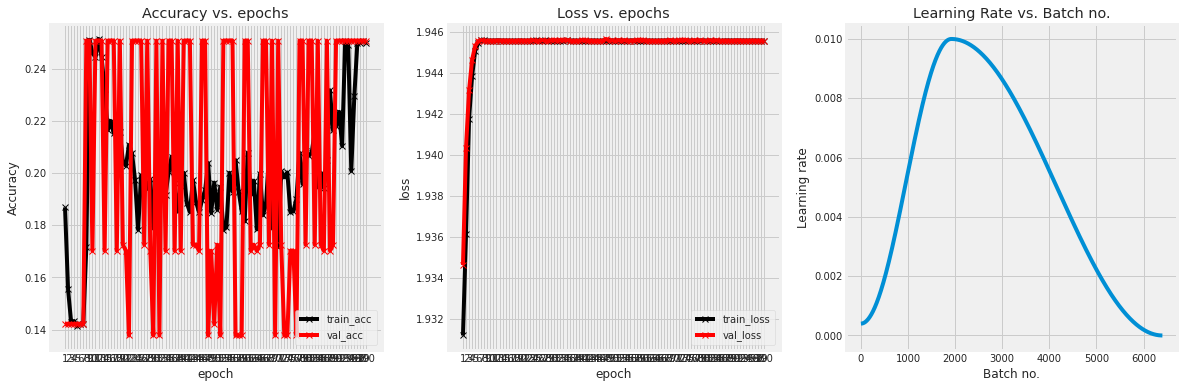

In [ ]:
# plotting score and loss

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_accuracies(history)
plt.subplot(1, 3, 2)
plot_losses(history)

plt.subplot(1, 3, 3)
plot_lrs(history)